In [1]:
import numpy as np
import pandas as pd
import zipfile

import matplotlib.pyplot as plt
import seaborn as sns
import pylab
from scipy import stats
from scipy.stats import probplot

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from scipy import stats

from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')
from pprint import pprint

from Wine_Review_Feature_Genetator import FeatureGenetator

### 1. Data loading
data source: https://www.kaggle.com/zynicide/wine-reviews?select=winemag-data_first150k.csv

#### Data fields
* id - No
* country - The country that the wine is from
* description - A few sentences from a sommelier describing the wine's taste, smell, look, feel, etc.
* designation - The vineyard within the winery where the grapes that made the wine are from
* points - The number of points WineEnthusiast rated the wine on a scale of 1-100 (though they say they only post reviews for
* price - The cost for a bottle of the wine
* province - The province or state that the wine is from
* region_1 - The wine growing area in a province or state (ie Napa)
* region_2 - Sometimes there are more specific regions specified within a wine growing area (ie Rutherford inside the Napa Valley), but this
* variety - The type of grapes used to make the wine (ie Pinot Noir)
* winery - The winery name

In [2]:
zip_file = 'C:/Users/ASER/1442_8172_bundle_archive.zip'
archive = zipfile.ZipFile(zip_file, 'r')
data_file = archive.open('winemag-data_first150k.csv')
data = pd.read_csv(data_file)
data.columns = ['id'] + list(data.columns[1:])
data.head(2)

,id,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez


#### Data with no information on prices is removed from the dataset

In [3]:
ind = data[data.price.isnull()].index
data = data.drop(ind, axis=0)
print(f'data.shape = {data.shape}')

data.shape = (137235, 11)


In [4]:
X = data.drop('price', axis=1)
y = data[['price']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f'X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}')
print(f'X_test.shape = {X_test.shape}, y_test.shape = {y_test.shape}')

X_train.shape = (102926, 10), y_train.shape = (102926, 1)
X_test.shape = (34309, 10), y_test.shape = (34309, 1)


### 2. Exploratory Data Analysis

### 2.1 Target variable distribution

In [5]:
y_train.price.describe()

count    102926.000000
mean         33.220003
std          36.966944
min           4.000000
25%          16.000000
50%          24.000000
75%          40.000000
max        2300.000000
Name: price, dtype: float64

In [6]:
n_zero_price = len(y_train[y_train.price.isnull()])
range_= y_train.price.describe()[-1] - y_train.price.describe()[3]
qtr_1 = y_train.price.describe()[4]
qtr_3 = y_train.price.describe()[-2]
IQR = qtr_3 - qtr_1
outliers = qtr_3 + 1.5 * IQR
outliers_set = y_train[y_train.price > outliers]
outliers_frac = round(len(outliers_set) / len(y_train), 3)


print(f'Mimimum price of the dataset is {y_train.price.describe()[3]}, maximum price - {y_train.price.describe()[-1]}')
print('Price range =', range_)
print(f'Median price = {y_train.price.describe()[5]}, mean = {round(y_train.price.describe()[1], 1)}')
print(f'Prices of 75% of the dataset are below {y_train.price.describe()[-2]}')
print(f'Interquartile range = {IQR}')
print(f'Ourlier prices starts from {outliers}, fraction of outliers in the dataset = {outliers_frac}')

Mimimum price of the dataset is 4.0, maximum price - 2300.0
Price range = 2296.0
Median price = 24.0, mean = 33.2
Prices of 75% of the dataset are below 40.0
Interquartile range = 24.0
Ourlier prices starts from 76.0, fraction of outliers in the dataset = 0.056


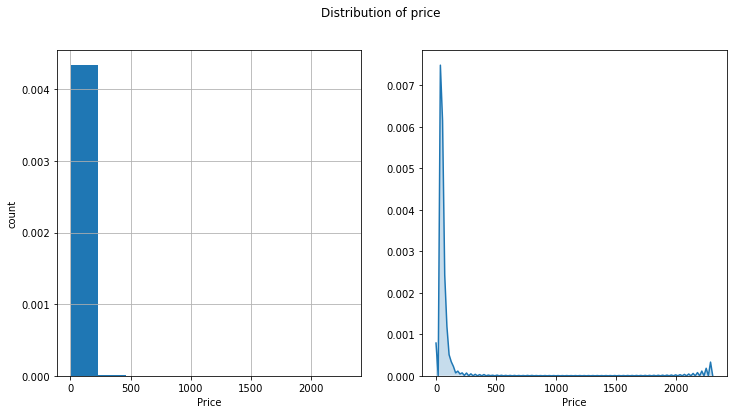

In [7]:
plt.figure(figsize = (12, 6))

plt.subplot(121)
y_train.price.hist(density=True)  # density=True  # shift + Tab = спарвка по функции
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(y_train.price, shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of price')
plt.show()

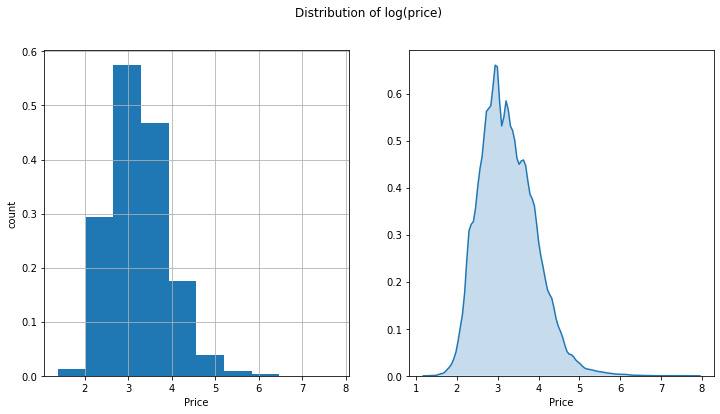

In [8]:
plt.figure(figsize = (12, 6))

plt.subplot(121)
np.log(y_train.price).hist(density=True)  # density=True  # shift + Tab = спарвка по функции
plt.ylabel('count')
plt.xlabel('Price')

plt.subplot(122)
sns.kdeplot(np.log(y_train.price), shade=True, legend=False)
plt.xlabel('Price')

plt.suptitle('Distribution of log(price)')
plt.show()

#### Q-Q plot for log(price)

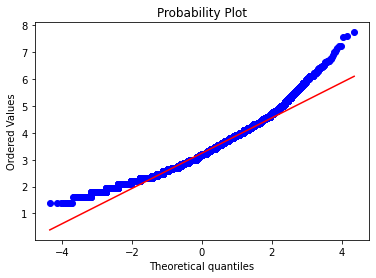

In [9]:
probplot(np.log(y_train.price), dist="norm", plot=pylab)
pylab.show()

#### Normal distribution test for np.log(y_train.price)

In [10]:
loc = np.log(y_train.price).mean()
scale = np.log(y_train.price).std()

for i in range(1, 4):
    true_value = stats.norm.cdf(i) - stats.norm.cdf(-i)
    sample_value = ((np.log(y_train.price) >= loc - i * scale) \
                    & (np.log(y_train.price) <= loc + i * scale)).sum() / y_train.shape[0]
        
    print(f'{i} sigma(s)')
    print(f'\ttheoretical:\t{true_value}')
    print(f'\tlog(price):\t{sample_value}')

1 sigma(s)
	theoretical:	0.6826894921370859
	log(price):	0.6651963546625731
2 sigma(s)
	theoretical:	0.9544997361036416
	log(price):	0.9654703379126751
3 sigma(s)
	theoretical:	0.9973002039367398
	log(price):	0.9930824087208285


### 2.2 Feature analysis

In [11]:
X_train.dtypes

id              int64
country        object
description    object
designation    object
points          int64
province       object
region_1       object
region_2       object
variety        object
winery         object
dtype: object

### A. Numerical variables

#### 2.2.1 Points

In [12]:
X_train.points.describe()

count    102926.000000
mean         87.789567
std           3.224489
min          80.000000
25%          86.000000
50%          88.000000
75%          90.000000
max         100.000000
Name: points, dtype: float64

No of cases with no points specified: 0


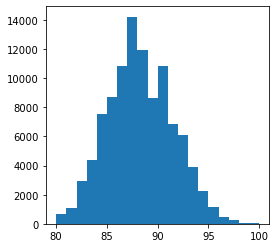

In [13]:
print('No of cases with no points specified:', len(X_train[X_train.points.isnull()]))
X_train.loc[:, 'points'].hist(figsize=(4,4), bins=20, grid=False);

#### Q-Q plot for X_train.points

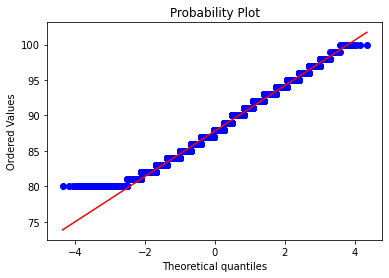

In [14]:
probplot(X_train.points, dist="norm", plot=pylab)
pylab.show()

#### Correlation of points with log(price)

In [15]:
corr = np.corrcoef(X_train.points, np.log(y_train.price))[0][1]
print('Correlation between points and log(price) =', round(corr, 3))

Correlation between points and log(price) = 0.611


#### Joint plot of points and log(price)

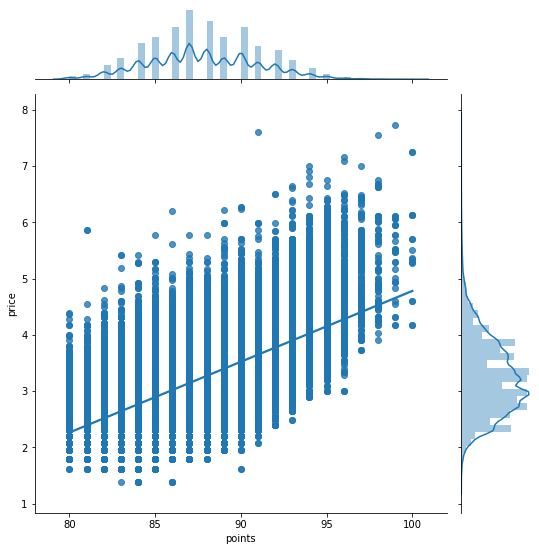

In [16]:
grid = sns.jointplot(X_train.points, np.log(y_train.price), kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)
plt.show()

### B. Categorical variables

For categorical variables we use a one-way analysis of variance (ANOVA) in order to test for differences in the means of the dependent variable broken down by the levels of the independent variable. 

ANOVA requires dependent variable to be normally distributed which is not the case with our dependent variable - price. 

As distribution of log(price) is more or less close to normal, log(price) is used in place of price. 
We also assume that distributions of log(price) in groups are homoscedastic and close to normal.  

In [17]:
def ANOVA(categorical_var):
    group_list = X_train[categorical_var].value_counts()
    n_min = 25
    a = [i for i in dict(group_list[group_list > n_min]).keys()]
    df = {}
    df1 = {}
    for i in a:
        group_price_list = np.log(y_train[X_train[categorical_var] == i].price).values
        group_mean_price = np.log(y_train[X_train[categorical_var] == i].price).mean()
        group_observations_n = len(y_train[X_train[categorical_var] == i])

        df[i] = group_mean_price, group_observations_n
        df1[i] = group_price_list, group_mean_price

    y_all_groups = []
    for item in df1.values():
        y_all_groups = np.concatenate([y_all_groups, item[0]])
    y_mean = y_all_groups.mean()

    SS_b = 0
    n_all_groups = 0
    for group_mean, n in df.values():
        SS_b += n * (group_mean - y_mean) ** 2
        n_all_groups += n

    SS_w = 0
    for group_values, group_mean in df1.values():
        SS_w += ((group_values - group_mean) **2 ).sum()

    k = len(df)
    k1 = k - 1
    k2 = n_all_groups - k

    sigma2_b = SS_b / k1
    sigma2_w = SS_w / k2

    F = sigma2_b / sigma2_w

    alpha = 0.05
    t = stats.f.ppf(1 - alpha, k1, k2)
    
    text_adj = dict({'country': 'countries', 'designation': 'designations', 
                     'province': 'provinces', 'region_1': 'regions in region_1', 
                     'region_2': 'regions in region_2',
                     'variety': 'varieties', 'winery': 'wineries'})
    
    print(f'nummber of {text_adj[categorical_var]} = {X_train[categorical_var].nunique()}')
    print(f'number of cases with no {categorical_var} specified: {len(X_train[X_train[categorical_var].isnull()])}')
    print(f'number of {text_adj[categorical_var]} with more than {n_min} observations = {len(df)}')
    print(f"F-test statistic for log(price) = {round(F, 3)}, 5% quantile = {round(t, 3)}")
    
    if F > t:
        print(f'Variance of mean log(price) by {categorical_var} is statistically significant')
    else:
        print(f'Variance of mean log(price) by {categorical_var} is statistically insignificant')
    
    
    df = pd.DataFrame(df).T
    df.columns = ['mean_price', 'n_observations']
    df.mean_price = round(np.exp(df.mean_price), 2)
    df.n_observations = df.n_observations.astype(int)
    df = df.sort_values(by=['mean_price'], ascending=False)
    
    return df

#### 2.2.2 Countries

In [18]:
df = ANOVA('country')

nummber of countries = 45
number of cases with no country specified: 5
number of countries with more than 25 observations = 27
F-test statistic for log(price) = 374.694, 5% quantile = 1.496
Variance of mean log(price) by country is statistically significant


#### Mean prices and number of observations by country

In [19]:
df.head(10)

,mean_price,n_observations
France,30.30,11080
Hungary,29.70,181
Italy,28.83,13986
Canada,28.74,149
US,28.21,46691
Germany,27.59,1762
Mexico,27.44,45
Israel,27.15,464
Austria,26.88,1876
Slovenia,25.06,58


In [20]:
df.sort_values(by=['n_observations'], ascending=False).head(10)

,mean_price,n_observations
US,28.21,46691
Italy,28.83,13986
France,30.30,11080
Spain,19.74,6089
Chile,15.84,4356
Argentina,16.61,4180
Australia,23.34,3676
Portugal,19.28,3143
New Zealand,21.78,2315
Austria,26.88,1876


#### 2.2.3 Designations

In [21]:
df = ANOVA('designation')

nummber of designations = 24792
number of cases with no designation specified: 31815
number of designations with more than 25 observations = 139
F-test statistic for log(price) = 60.434, 5% quantile = 1.207
Variance of mean log(price) by designation is statistically significant


In [22]:
df.head(10)

,mean_price,n_observations
Cannubi,90.36,33
Les Clos Grand Cru,85.50,26
Vintage,65.76,77
Pisoni Vineyard,62.45,26
Stagecoach Vineyard,59.12,62
Lewis Vineyard,53.47,27
Monte Rosso Vineyard,53.05,26
Premier Cru,51.24,35
Garys' Vineyard,51.02,64
Shea Vineyard,50.09,32


In [23]:
df.sort_values(by=['n_observations'], ascending=False).head(10)

,mean_price,n_observations
Reserve,27.36,2035
Reserva,16.21,1327
Estate,28.60,1187
Riserva,40.56,436
Brut,23.17,422
Crianza,16.34,365
Estate Grown,30.68,331
Estate Bottled,22.51,301
Dry,15.75,262
Old Vine,19.94,253


#### 2.2.4 Provinces

In [24]:
df = ANOVA('province')

nummber of provinces = 428
number of cases with no province specified: 5
number of provinces with more than 25 observations = 140
F-test statistic for log(price) = 173.368, 5% quantile = 1.205
Variance of mean log(price) by province is statistically significant


In [25]:
df.head(10)

,mean_price,n_observations
Champagne,73.11,826
Burgundy,50.05,2481
Tokaji,47.26,57
Tokaj,41.58,26
Port,39.97,484
Rheingau,39.28,264
Wachau,39.12,256
Villány,38.70,41
Judean Hills,36.79,94
Tuscany,36.43,4431


In [26]:
df.sort_values(by=['n_observations'], ascending=False).head(10)

,mean_price,n_observations
California,29.40,33280
Washington,25.80,7334
Tuscany,36.43,4431
Northern Spain,21.40,3627
Mendoza Province,16.72,3545
Oregon,29.91,3415
Burgundy,50.05,2481
Veneto,25.68,2303
South Australia,26.65,2189
Piedmont,35.17,2171


#### 2.2.5 Region 1 & region 2

In [27]:
df = ANOVA('region_1')

nummber of regions in region_1 = 1155
number of cases with no region_1 specified: 17191
number of regions in region_1 with more than 25 observations = 373
F-test statistic for log(price) = 170.632, 5% quantile = 1.124
Variance of mean log(price) by region_1 is statistically significant


In [28]:
df.head(10)

,mean_price,n_observations
Corton-Charlemagne,150.07,30
Côte Rôtie,119.21,46
Hermitage,117.40,109
Vosne-Romanée,92.47,38
Pauillac,90.32,71
Puligny-Montrachet,89.88,94
Chambolle-Musigny,87.92,44
Clarendon,84.10,46
Pomerol,81.77,33
Nuits-St.-Georges,80.75,97


In [29]:
df.sort_values(by=['n_observations'], ascending=False).head(10)

,mean_price,n_observations
Napa Valley,40.08,4672
Columbia Valley (WA),23.14,3727
Mendoza,15.75,2686
Russian River Valley,34.32,2661
California,12.92,2624
Paso Robles,27.08,2287
Willamette Valley,28.81,1562
Rioja,24.06,1415
Sonoma County,23.84,1404
Toscana,40.10,1250


In [30]:
df = ANOVA('region_2')

nummber of regions in region_2 = 18
number of cases with no region_2 specified: 57318
number of regions in region_2 with more than 25 observations = 18
F-test statistic for log(price) = 896.821, 5% quantile = 1.623
Variance of mean log(price) by region_2 is statistically significant


In [31]:
df.head(10)

,mean_price,n_observations
Napa,44.17,6605
South Coast,33.32,155
Napa-Sonoma,32.26,1236
Sonoma,32.22,8406
Willamette Valley,32.21,2356
Central Coast,28.20,9686
Columbia Valley,26.15,6894
Mendocino/Lake Counties,25.69,1809
Southern Oregon,24.48,502
Oregon Other,24.00,486


In [32]:
df.sort_values(by=['n_observations'], ascending=False).head(10)

,mean_price,n_observations
Central Coast,28.20,9686
Sonoma,32.22,8406
Columbia Valley,26.15,6894
Napa,44.17,6605
California Other,13.00,2667
Willamette Valley,32.21,2356
Mendocino/Lake Counties,25.69,1809
Napa-Sonoma,32.26,1236
Sierra Foothills,23.05,1232
Finger Lakes,18.27,1134


#### 2.2.6 Varieties

In [33]:
df = ANOVA('variety')

nummber of varieties = 592
number of cases with no variety specified: 0
number of varieties with more than 25 observations = 154
F-test statistic for log(price) = 160.807, 5% quantile = 1.195
Variance of mean log(price) by variety is statistically significant


In [34]:
df.head(10)

,mean_price,n_observations
Tokaji,58.07,61
Nebbiolo,57.87,1114
Champagne Blend,57.41,765
Sangiovese Grosso,52.02,677
Tinto Fino,52.01,61
Spätburgunder,50.12,40
Sagrantino,47.35,67
Cabernet Blend,44.71,223
Cabernet Sauvignon-Cabernet Franc,40.48,30
Petite Verdot,39.25,60


In [35]:
df.sort_values(by=['n_observations'], ascending=False).head(10)

,mean_price,n_observations
Chardonnay,24.69,10271
Pinot Noir,37.42,10230
Cabernet Sauvignon,31.93,9595
Red Blend,28.62,6978
Sauvignon Blanc,17.00,4504
Syrah,30.36,4328
Riesling,22.90,3912
Merlot,21.29,3745
Bordeaux-style Red Blend,35.76,3411
Zinfandel,24.35,2832


#### 2.2.7 Wineries

In [36]:
df = ANOVA('winery')

nummber of wineries = 12961
number of cases with no winery specified: 0
number of wineries with more than 25 observations = 871
F-test statistic for log(price) = 50.582, 5% quantile = 1.081
Variance of mean log(price) by winery is statistically significant


In [37]:
df.head(10)

,mean_price,n_observations
Tenuta dell'Ornellaia,204.24,26
Domaine Leflaive,180.50,31
Perrier Jouët,136.30,28
Le Macchiole,123.73,35
M. Chapoutier,90.59,54
Goldschmidt,88.81,26
Marchesi Antinori,88.24,41
Clarendon Hills,85.08,45
Bouchard Père & Fils,84.27,147
Emilio Moro,84.00,33


In [38]:
df.sort_values(by=['n_observations'], ascending=False).head(10)

,mean_price,n_observations
Williams Selyem,55.09,280
Testarossa,47.09,212
DFJ Vinhos,9.57,185
Chateau Ste. Michelle,19.95,176
Kendall-Jackson,23.13,170
Columbia Crest,14.60,166
Concha y Toro,21.08,166
De Loach,30.54,150
Trapiche,19.48,149
Joseph Drouhin,55.38,148


### 3. Feature engineering

The new variables are generated by FeatureGenetator (Wine_Review_Feature_Genetator.py).
FeatureGenetator performs target encoding of cathegorical variables country, designation, province, region_1, region_2, variety and winery and generates new variables with median prices of each level: 
* MedPriceByCountry, 
* MedPriceByDesignation, 
* MedPriceByProvince, 
* MedPriceByRegion, 
* MedPriceByVariety, 
* MedPriceByWinery.

5 of them (excluding MedPriceByDesignation) were used in principal component analysis to generate 3 new composit variables:
* pca_composit_1, 
* pca_composit_2, 
* pca_composit_3.

3 of them (MedPriceByRegion, MedPriceByVariety, MedPriceByWinery) were clustered and split into binary variables: Cluster_1 and Cluster_2.

Variable points is split into 5 groups and new cathegorical variable points_group is generated.

Cathegorical variable points_group were used to generate binary variables PG_1, PG_2, PG_3, PG_4, PG_5

In [39]:
features = FeatureGenetator()
features.fit(X_train, y_train)

X_train = features.transform(X_train)
X_test = features.transform(X_test)

In [40]:
X_train.columns

Index(['id', 'country', 'description', 'designation', 'points', 'province',
       'region_1', 'region_2', 'variety', 'winery', 'MedPriceByCountry',
       'MedPriceByDesignation', 'MedPriceByProvince', 'MedPriceByRegion',
       'MedPriceByVariety', 'MedPriceByWinery', 'points_group', 'PG_1', 'PG_2',
       'PG_3', 'PG_4', 'PG_5', 'Cluster_1', 'Cluster_2', 'pca_composit_1',
       'pca_composit_2', 'pca_composit_3'],
      dtype='object')

### 4. Target encoded variables analysis - numeric variables

In [41]:
numeric_vars = ['MedPriceByCountry', 'MedPriceByDesignation', 'MedPriceByProvince', 
                'MedPriceByRegion', 'MedPriceByVariety', 'MedPriceByWinery']
round(X_train[numeric_vars].describe(include="all"), 1)

,MedPriceByCountry,MedPriceByDesignation,MedPriceByProvince,MedPriceByRegion,MedPriceByVariety,MedPriceByWinery
count,102826.0,13497.0,100676.0,44680.0,89543.0,18266.0
mean,24.2,24.4,27.0,30.0,30.3,33.1
std,4.7,11.0,12.9,12.2,11.4,16.9
min,9.0,8.0,5.0,10.0,10.0,7.0
25%,20.0,15.5,18.0,22.0,24.0,22.0
50%,25.0,24.0,30.0,29.0,28.0,30.0
75%,28.0,28.0,32.0,39.0,40.0,41.0
max,28.0,95.0,87.0,125.0,125.0,140.0


##### PCA composit variables

PCA explained variance ratio: [0.45980073 0.19227708 0.16529605 0.11999801 0.06262814]



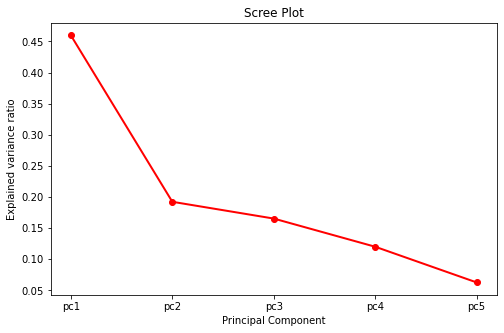



The first three components explan 0.8174 of variance



In [42]:
scaler = StandardScaler()
a = X_train[['MedPriceByCountry', 'MedPriceByProvince', 'MedPriceByRegion', 
               'MedPriceByVariety', 'MedPriceByWinery']].fillna(0)
        
a = scaler.fit_transform(a)        
pca = PCA(n_components=5)
pca.fit(a)
print(f'PCA explained variance ratio: {pca.explained_variance_ratio_}\n')

fig = plt.figure(figsize=(8,5))
plt.plot(['pc1','pc2','pc3','pc4', 'pc5'], pca.explained_variance_ratio_, 'ro-', linewidth=2)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Explained variance ratio')
plt.show()

print('\n')
print(f'The first three components explan {round(pca.explained_variance_ratio_[:3].sum(),4)} of variance\n')

### 4.1 Analysis of dependence of target on target encoded variables
#### Correlations between the target and each of the target encoded variables

In [43]:
var_list = ['MedPriceByVariety','MedPriceByProvince', 'MedPriceByCountry', 
            'MedPriceByRegion', 'MedPriceByWinery', 'MedPriceByDesignation',
            'pca_composit_1', 'pca_composit_2', 'pca_composit_3']

print('Correlation between log(price) and target encoded variable:')
for var in var_list:
    corr = np.corrcoef(X_train[var].fillna(0), np.log(y_train.price))[0][1]
    if var[:3] == 'pca':
        print(f'{var}:\t\t {round(corr, 3)}')
    else:
        print(f'{var}:\t {round(corr, 3)}')

Correlation between log(price) and target encoded variable:
MedPriceByVariety:	 0.307
MedPriceByProvince:	 0.304
MedPriceByCountry:	 0.272
MedPriceByRegion:	 0.254
MedPriceByWinery:	 0.147
MedPriceByDesignation:	 0.038
pca_composit_1:		 0.371
pca_composit_2:		 -0.165
pca_composit_3:		 0.064


### 4.2 Normality tests

In [44]:
def norm_test1(keys):
    fig, axes = plt.subplots(ncols=len(keys))
    fig.set_size_inches(4 * len(keys), 4)
    axes = axes.flatten()

    for key, ax in zip(keys, axes):
        ax.hist(X_train[key], density=True)

        loc = X_train[key].mean()
        scale = X_train[key].std()

        x_left, x_right = ax.get_xlim()
        x = np.linspace(x_left, x_right, 10000)
        y = stats.norm.pdf(x, loc=loc, scale=scale)

        ax.plot(x, y, linestyle='dashed')
        ax.set_title(key)
        
def norm_test2(keys):
    fig, axes = plt.subplots(ncols=len(keys))
    fig.set_size_inches(4 * len(keys), 4)
    axes = axes.flatten()

    for key, ax in zip(keys, axes):
        samples = X_train[key]

        loc = samples.mean()
        scale = samples.std()

        interval = np.linspace(0, 1, samples.shape[0])[1:-1]
        x = stats.norm.ppf(interval, loc=loc, scale=scale)
        y = np.quantile(samples, interval)

        ax.scatter(x, y, s=5)
        ax.plot(x, x, color='C1', linestyle='dashed')

        ax.set_title(key)
        ax.set_xlabel('theoretical quantiles')
        ax.set_ylabel('sample quantiles')
        
def norm_test3(keys):
    for key in keys:
        print(key)

        samples = X_train[key]

        loc = samples.mean()
        scale = samples.std()

        for i in range(1, 4):
            true_value = stats.norm.cdf(i) - stats.norm.cdf(-i)
            sample_value = ((samples >= loc - i * scale) & (samples <= loc + i * scale)).sum() / samples.shape[0]

            print(f'{i} sigma(s)')
            print(f'\ttheoretical:\t{true_value}')
            print(f'\tsample:\t\t{sample_value}')

        print()    

#### 4.2.1 Normality tests of pca_composit variables

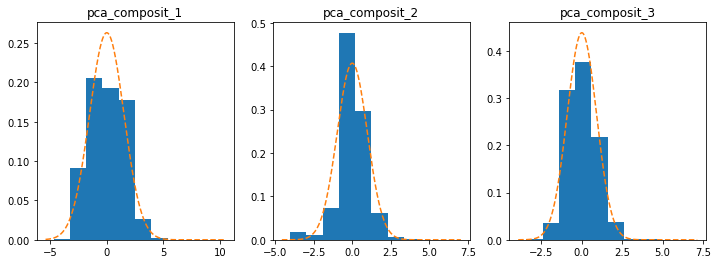

In [45]:
keys = ['pca_composit_1', 'pca_composit_2', 'pca_composit_3']
norm_test1(keys)

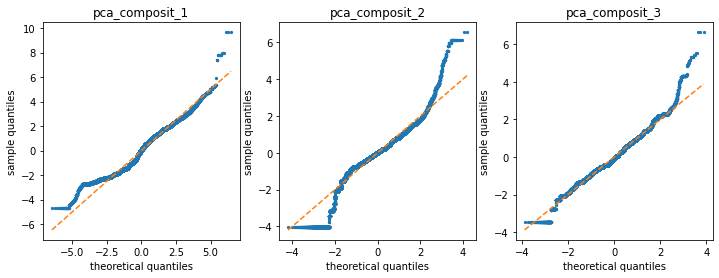

In [46]:
norm_test2(keys)

In [47]:
norm_test3(keys)

pca_composit_1
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.6048714610496861
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9842508209781785
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9983386122068282

pca_composit_2
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.7817752560091716
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9549967938130307
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9768182966403047

pca_composit_3
1 sigma(s)
	theoretical:	0.6826894921370859
	sample:		0.6967238598604822
2 sigma(s)
	theoretical:	0.9544997361036416
	sample:		0.9492548044225949
3 sigma(s)
	theoretical:	0.9973002039367398
	sample:		0.9953364553174125



#### 4.2.2 Normality tests of other numeric target encoded variables 

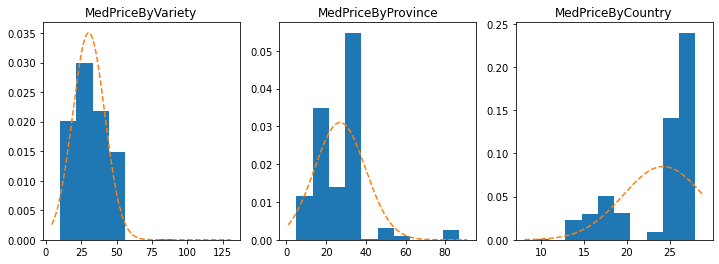

In [48]:
keys = ['MedPriceByVariety','MedPriceByProvince', 'MedPriceByCountry']
norm_test1(keys)

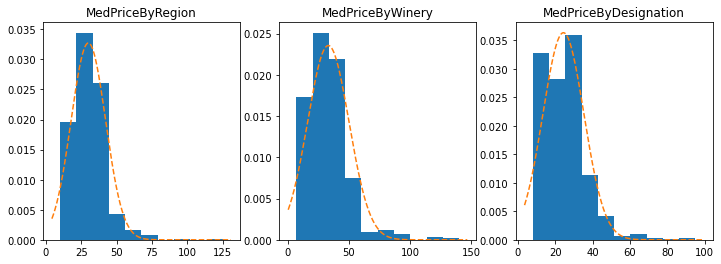

In [49]:
keys = ['MedPriceByRegion', 'MedPriceByWinery', 'MedPriceByDesignation']
norm_test1(keys)

### 4.3 Correlation matrix of numeric target encoded variables

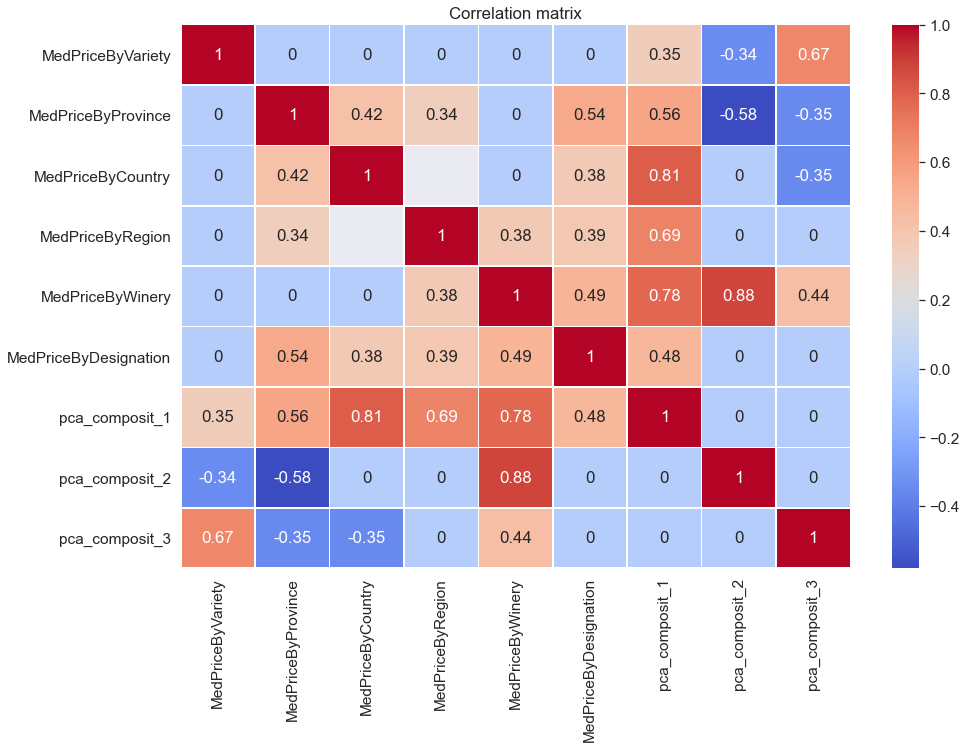

In [50]:
df = X_train[var_list]
plt.figure(figsize = (15,10))

sns.set(font_scale=1.4)

corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0 

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

### 5. Target encoded variables analysis - categorical / binary variables

### 5.1 Categorical variable points_group

Correlation between points and points_group:

                 points  points_group
points        1.000000      0.937017
points_group  0.937017      1.000000



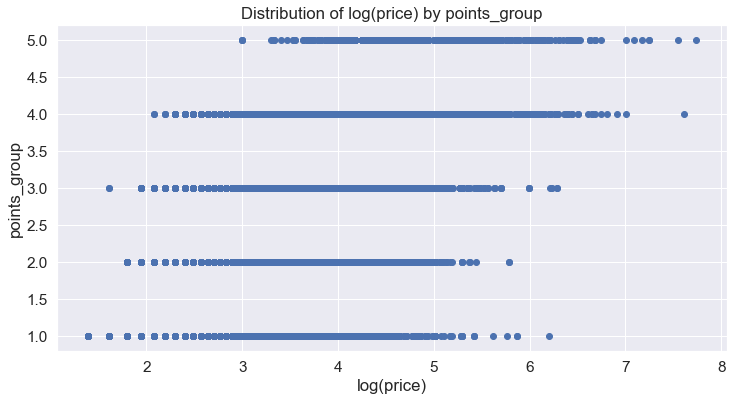

In [51]:
print(f"Correlation between points and points_group:\n\n {X_train[['points', 'points_group']].corr()}\n")
plt.figure(figsize=(12, 6))
plt.scatter(np.log(y_train['price']), X_train['points_group'])

plt.xlabel('log(price)')
plt.ylabel('points_group')
plt.title('Distribution of log(price) by points_group')
plt.show()

In [52]:
def binary_var(var_name):
    counts = X_train[var_name].value_counts()

    plt.figure(figsize=(6,4))    
    plt.title(var_name)
    sns.barplot(counts.index, counts.values)

    plt.show()

### 5.2 Binary variables PG_1, PG_2, PG_3, PG_4, PG_5

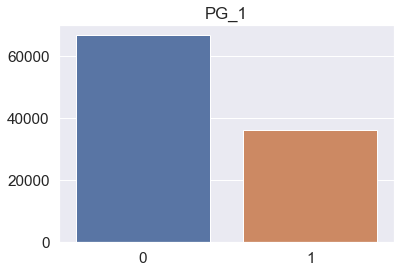

In [53]:
binary_var('PG_1')

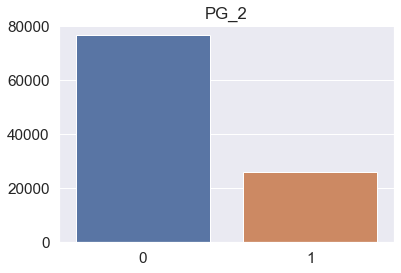

In [54]:
binary_var('PG_2')

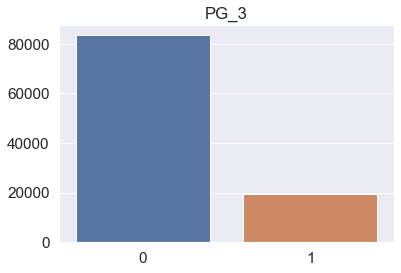

In [55]:
binary_var('PG_3')

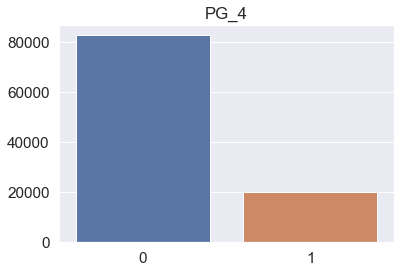

In [56]:
binary_var('PG_4')

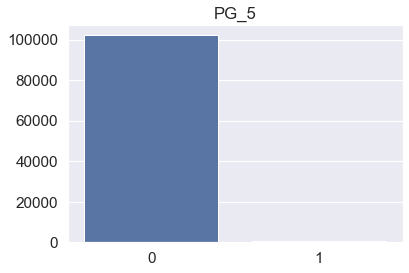

In [57]:
binary_var('PG_5')

### 5.3 Binary variables Cluster_1, Cluster_2

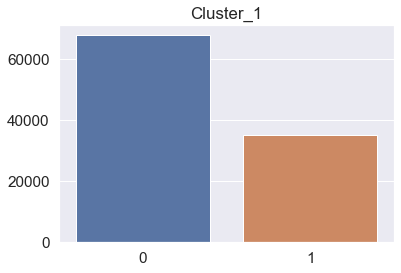

In [58]:
binary_var('Cluster_1')

### 6. Selection of variables for linear regression

Although linear regression is not the best fit for our dataset, to compare the results generated by linear regression vs the ones of non-linear models (LGBMRegressor, RandomForestRegressor, VotingRegressor), here we select variables for linear regression.

Distribution of points and pca_composit variables is more or less close to normal. All 4 variables have low correlation between each other and acceptable correlation with the target (0.611, 0.371, -0.165 and 0.064 correspondingly).

Distributions of two other numerical target encoded variables - MedPriceByProvince and MedPriceByCountry significantly departs from normal. Another pair - MedPriceByWinery and MedPriceByDesignation has low correlation with the target (0.147 and 0.038 correspondingly). We should also notice that MedPriceByWinery is strongly correlated with pca_composit_1 and pca_composit_2 (0.78 and 0.88) - another argument for rejection. To address multicollinearity problem, we should also reject MedPriceByVariety and  MedPriceByRegion. They are highly correlated with pca_composit variables (0.67 and 0.69 correspondingly).

Categorical variable points_group looks promising but it is highly correlated with points (corr = 0.937). So, between two of them points has been chosen as the more informative.Among 5 binary variables PG1, PG_2, PG_3, PG_4 and PG_5, PG_1 is too large to influence the target while PG_5 does not contain enough observations. Binary variable Cluster_1 is added to the list.

So, the final selection:
['points', 'pca_composit_1', 'pca_composit_2', 'pca_composit_3', 'PG_2', 'PG_3', 'PG_4', 'Cluster_1']

In [59]:
var_list = ['points', 'pca_composit_1', 'pca_composit_2','pca_composit_3',            
           'PG_2', 'PG_3', 'PG_4', 'Cluster_1']

X_train_linear = np.array(X_train[var_list].fillna(0))
model = LinearRegression(fit_intercept = True, normalize=True).fit(X_train_linear, np.log(y_train))

r2 = model.score(X_train_linear, np.log(y_train.price))
print(f'The coefficient of determination = {r2}')

n = X_train.shape[0]
p = len(var_list) + 1
r2_adj = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print(f'Adjusted coefficient of determination = {r2_adj}')

The coefficient of determination = 0.46923451169935093
Adjusted coefficient of determination = 0.46918809627905955


#### Statistical analysis of the regression equation

In [60]:
k1 = len(var_list)
k2 = n - k1 - 1
F = (r2 / k1) / ((1 - r2) / k2)

alpha = 0.05
t = stats.f.ppf(1 - alpha, k1, k2)
print(f"F-test statistic = {round(F, 3)}, 5% quantile = {round(t, 3)}.")
print('The regression equation is statistically significant')

F-test statistic = 11373.245, 5% quantile = 1.939.
The regression equation is statistically significant


Mean of residuals = -2.4819567171963356e-16


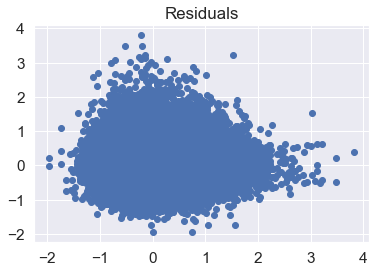

In [61]:
b = model.coef_[0]
y_pred = X_train_linear.dot(b) + model.intercept_

e = np.log(y_train.price) - y_pred
print(f'Mean of residuals = {e.mean()}')
plt.scatter(e[1:],e[:-1])
plt.title('Residuals')
plt.show()

#### Q-Q plot for residuals

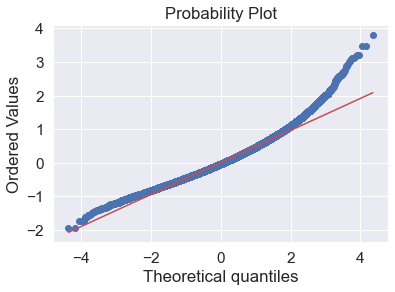

In [62]:
probplot(e, dist="norm", plot=pylab)
pylab.show()

The distribution of residuals departs from normal, so linear regression is not the best fit for our dataset.

Non-linear predictive models are used for wine price prediction in Wine_Review_predicvive_models